In [1]:
import os
import sys
from datetime import datetime

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.dataset import CICIDS2017
from UNSWNB15.dataset import UNSWNB15

from scripts.models.pytorch.MLP import NetworkIntrusionMLP
from scripts.models.pytorch.visualization import display_loss
from scripts.models.pytorch.train import train

from scripts.models.random_forest.random_forest import train_random_forest

from NIDS_attacks.substitut import attack_substitut
from NIDS_attacks.fgsm import attack_fgsm
from NIDS_attacks.bounds_constrains import apply_bounds_constraints
from NIDS_attacks.integers_constrains import apply_integer_constraints

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(
    root_dir=root_dir,
    log_name="test_substitut",
)
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")

2025-11-27 08:22:17,750 - INFO - Logger initialized for 'test_substitut_20251127_082217'


In [2]:
dataset = CICIDS2017(
    dataset_size="full",
    logger=logger
).optimize_memory().encode()

2025-11-27 08:22:17,758 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-27 08:22:18,470 - INFO - Loading dataset into DataFrame
2025-11-27 08:22:32,017 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-27 08:22:47,925 - INFO - ============================================================
2025-11-27 08:22:47,926 - INFO - Preprocessing completed successfully
2025-11-27 08:22:47,926 - INFO - Final dimensions: 1,940,693 rows x 71 columns
2025-11-27 08:22:47,927 - INFO - Total rows removed: 273,776 (12.36%)
2025-11-27 08:22:47,928 - INFO - data retention rate: 87.64%
2025-11-27 08:22:47,928 - INFO - ============================================================
2025-11-27 08:22:47,930 - INFO - Optimizing memory usage of the dataset...
2025-11-27 08:22:47,933 - INFO - Initial memory usage: 1066.05 MB
2025-11-27 08:22:48,523 - INFO - Optimized memory usage: 555.24 MB
2025-11-27 08:22:48,524 - INFO - Memory reduction: 510.82 MB (47.92%)
20

In [3]:
X_train, X_test, y_train, y_test = dataset.subset(size=900*1000, multi_class=False).split(
    one_hot=True,
    test_size=0.2,
    apply_smote=True
)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

2025-11-27 08:22:49,336 - INFO - Subsetting dataset to size: 900000...
2025-11-27 08:22:49,345 - INFO - Class distribution before subsetting:
2025-11-27 08:22:49,346 - INFO -   Class 0: 1528113 samples
2025-11-27 08:22:49,346 - INFO -   Class 1: 412580 samples
2025-11-27 08:22:49,432 - INFO - Subsetted dataset to size: 862580
2025-11-27 08:22:50,199 - INFO - Splitting dataset into training and testing sets...
2025-11-27 08:22:55,141 - INFO - Class distribution before SMOTE:
2025-11-27 08:22:55,141 - INFO -   Class 0.0: 360137 samples
2025-11-27 08:22:55,142 - INFO -   Class 1.0: 329927 samples
2025-11-27 08:22:55,145 - INFO - Class distribution after SMOTE:
2025-11-27 08:22:55,146 - INFO -   Class 0.0: 360137 samples
2025-11-27 08:22:55,146 - INFO -   Class 1.0: 329927 samples


Train set shape: (690064, 70)
Test set shape: (172516, 70)


Initialisation des données


In [4]:
# Train Random Forest using standalone function and plot CV scores
logger.info("Training Random Forest with cross-validation using train_random_forest...")
rf_model, cv_scores = train_random_forest(
    X_train,
    y_train,
    n_estimators=10,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=0,
    cv=5,
    class_weight=None,
    logger=None
)

if cv_scores != None:
    print("\n" + "="*50)
    print("CROSS-VALIDATION RESULTS")
    print("="*50)
    print(f"CV Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    # Plot CV scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cv_scores)+1), cv_scores, marker='o', markersize=10, linewidth=2, color='green')
    plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', 
                label=f'Mean: {cv_scores.mean():.4f}')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Decision Tree Cross-Validation Scores', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

2025-11-27 08:22:55,188 - INFO - Training Random Forest with cross-validation using train_random_forest...


Evaluation of the Random Forest Before attack

2025-11-27 08:22:59,675 - INFO - Running analysis for scikit-learn model: RandomForest before adversarial attack


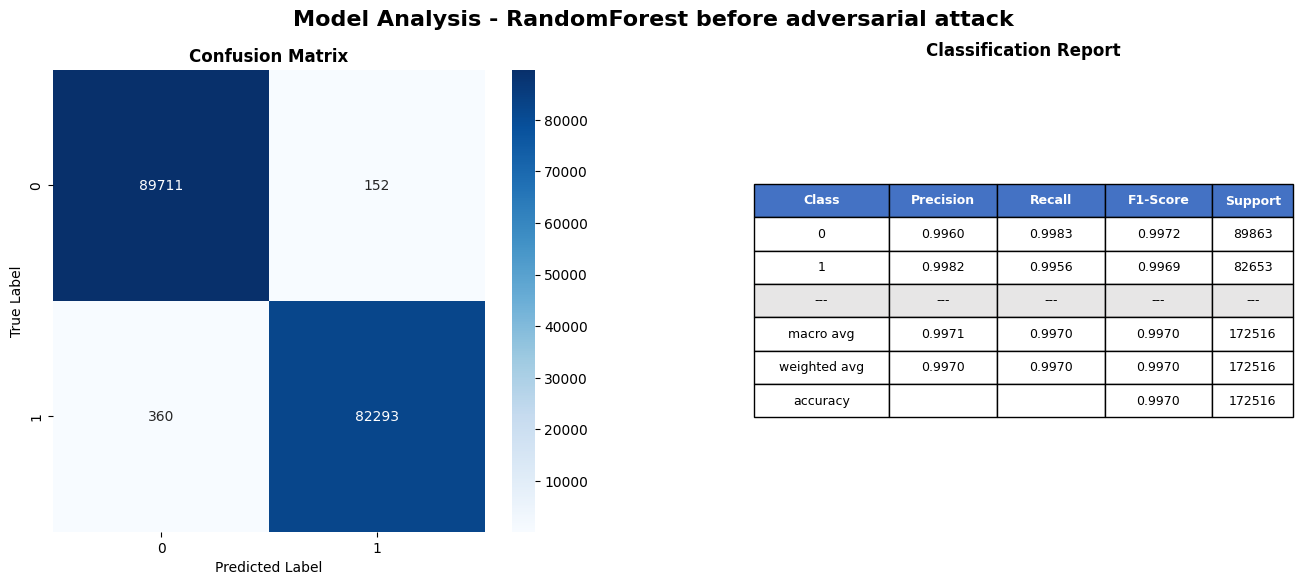

In [5]:
# Evaluate model
cm_rf, cr = perform_model_analysis(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    title="RandomForest before adversarial attack",
    root_dir=root_dir,
    plot=True
)

Generation of the substitut for the attack

2025-11-27 08:23:00,174 - INFO - Running analysis for scikit-learn model: RandomForest Substitut
Loss: 0.0687, Val Loss: 0.0682, LR: 0.010000: 100%|██████████| 100/100 [02:15<00:00,  1.35s/it]
2025-11-27 08:25:16,876 - INFO - Plotting loss curve...
2025-11-27 08:25:17,795 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/results/loss_plots/Substitute_MLPRandomForest Substitut_100_loss.png


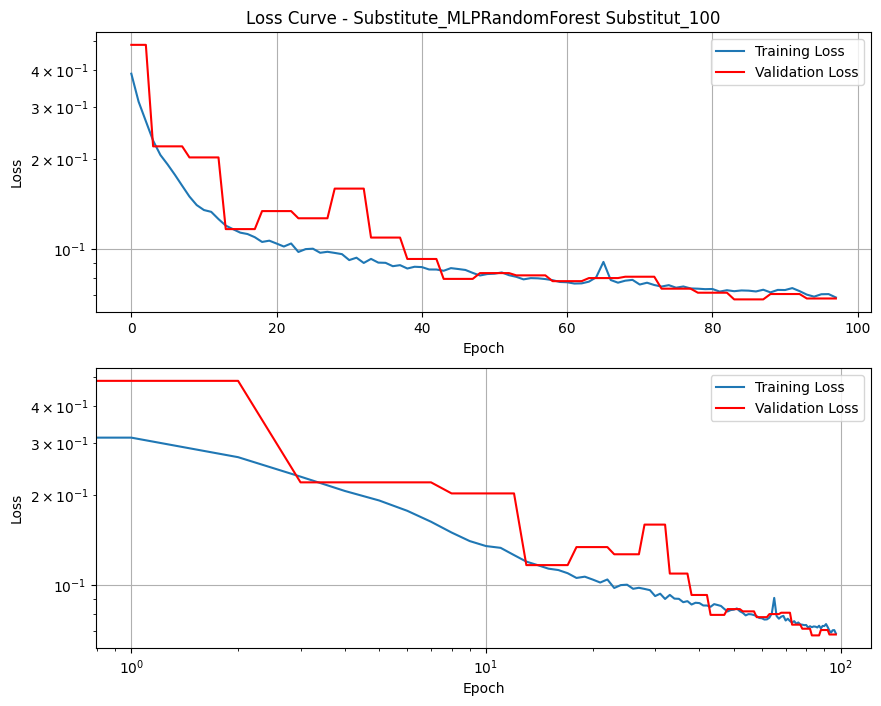

2025-11-27 08:25:18,001 - INFO - Running analysis for PyTorch model: Substitute_MLPRandomForest Substitut_100 on device: cuda:0


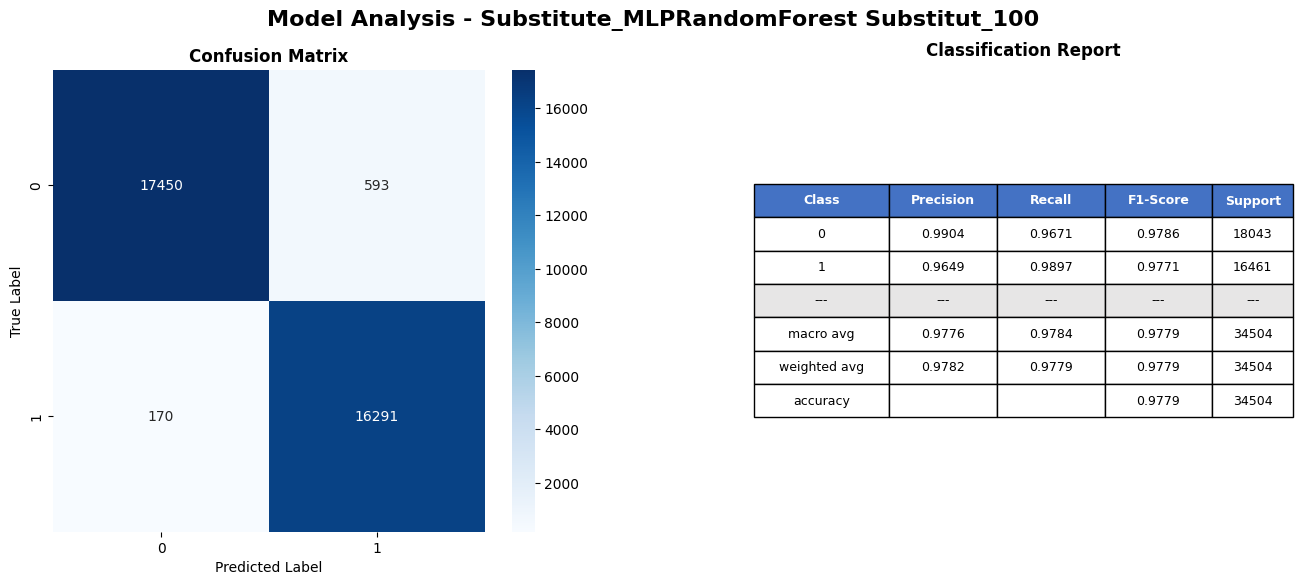

In [6]:
sub, cm, cr = attack_substitut(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    root_dir=root_dir,
    logger=lm.logger,
    model_name="RandomForest Substitut",
    plot_analysis=True,
    plot_loss=True,
    save_fig=True,
    device=device
)

Attack

In [7]:
x_adv = torch.FloatTensor(X_test).clone().detach().requires_grad_(True).to(device)
criterion = nn.CrossEntropyLoss()

# Targeting the 'benign' class
target = torch.LongTensor([0]).repeat(x_adv.shape[0]).to(device)

print("Target class for the attack:", target.shape)

sub = sub.to(device)
sub.eval()
epsilon = 1

# Initial prediction
initial_x_adv, initial_loss, initial_pred = attack_fgsm(
    model=sub,
    criterion=criterion,
    x_val=x_adv,
    target=target,
    eps=0.0
)

print("Initial prediction on adversarial input:", initial_pred.argmax(axis=1))

list_x_adv = [initial_x_adv]
for iter in range(100):
    new_x_adv, loss, pred = attack_fgsm(
        model=sub,
        criterion=criterion,
        x_val=x_adv,
        target=target,
        eps=epsilon
    )

    # Recompute derived features
    #x_adv_rf = compute_features_batch(new_x_adv,dico = dico_encoded)

    # Apply bounds constraints
    x_adv = apply_bounds_constraints(
        x_adv=new_x_adv,
        x_original=x_adv,
        modifiable_indices=dataset.MODIFIABLE_FEATURES,
        min_vals=torch.tensor(X_train,dtype=torch.float32).min(axis=0).values.to(device),
        max_vals=torch.tensor(X_train,dtype=torch.float32).max(axis=0).values.to(device)
    )

    # Check if attack is successful
    if pred.argmax(axis=1).sum() == 0:
        x_adv = apply_integer_constraints(
        x_adv=new_x_adv,
        integer_indices=dataset.INTEGER_INDICES
        )

        # Final evaluation without perturbation
        x_adv, loss, pred = attack_fgsm(
            model=sub,
            criterion=criterion,
            x_val=x_adv,
            target=target,
            eps=0.0
        )

        # Check if attack is successful after applying constraints
        if pred.argmax(axis=1).sum() == 0:
            print(f"Successful adversarial example found at iteration {iter+1}")
            break


print(f"Adversarial input after {iter+1} iterations:", pred.argmax(axis=1))
diff_adv = x_adv - initial_x_adv
print("Magnitude of perturbation:")
print("Mean:", torch.norm(diff_adv, dim=1).cpu().numpy().mean())
print("Min:", torch.norm(diff_adv, dim=1).cpu().numpy().min())
print("Max:", torch.norm(diff_adv, dim=1).cpu().numpy().max())
print("Std:", torch.norm(diff_adv, dim=1).cpu().numpy().std())


Target class for the attack: torch.Size([172516])
Initial prediction on adversarial input: [0 0 1 ... 0 0 1]
Adversarial input after 100 iterations: [0 0 0 ... 0 0 0]
Magnitude of perturbation:
Mean: 845.3367
Min: 5.5677643
Max: 3.8111416e+07
Std: 104116.18


2025-11-27 08:25:38,109 - INFO - Running analysis for PyTorch model: Substitute Model on device: cuda


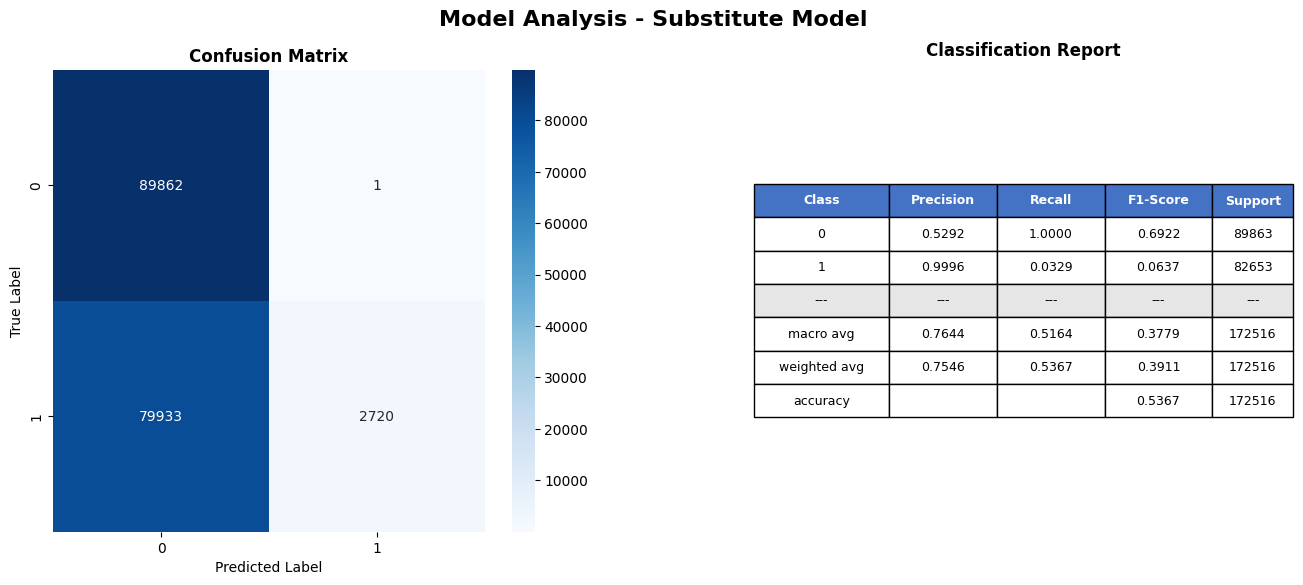

In [8]:
cm_rf, cr = perform_model_analysis(
    model=sub,
    X_test=x_adv,
    y_test=y_test,
    logger=logger,
    title="Substitute Model",
    root_dir=root_dir,
    plot=True
)

2025-11-27 08:34:28,943 - INFO - Running analysis for scikit-learn model: Random Forest after adversarial attack


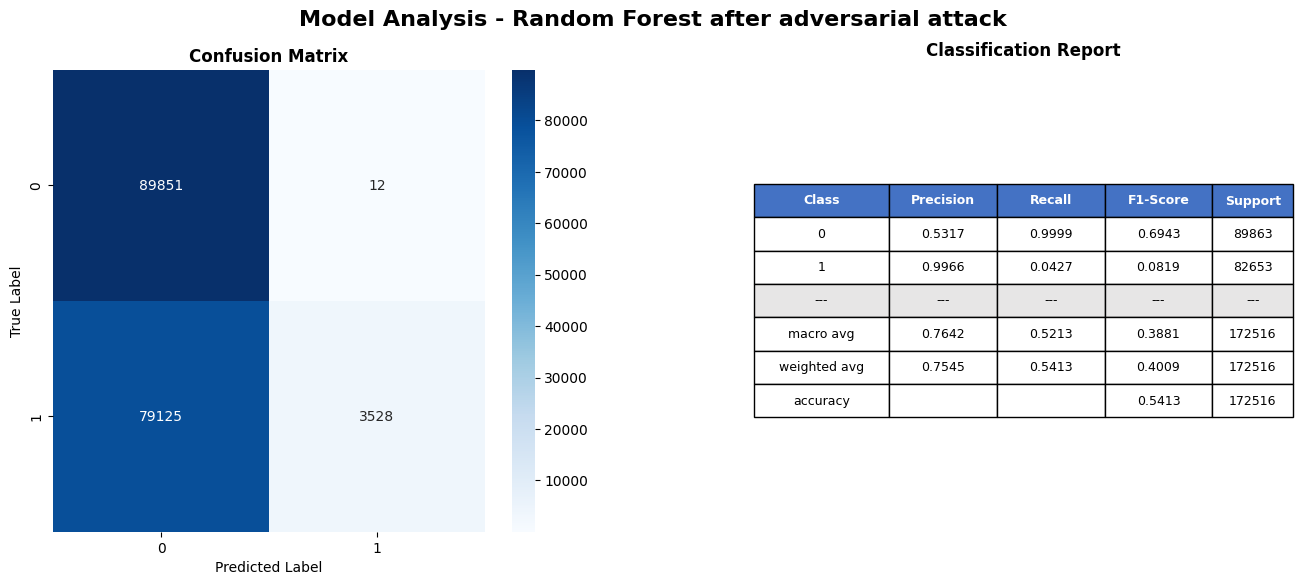

In [10]:
cm_rf, cr = perform_model_analysis(
    model=rf_model,
    X_test=x_adv.cpu().numpy(),
    y_test=y_test,
    logger=logger,
    title="Random Forest after adversarial attack",
    root_dir=root_dir,
    plot=True
)